# Graph Attention Network

In [15]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
from torch_geometric.nn import GATConv
import torch.nn.functional as F
import numpy as np
import torch.nn as nn
import torch_geometric.utils

2.5.1+cu121
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [16]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [17]:
dataset = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())

Processing...
Done!


In [18]:
# Характеристики графа
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: CiteSeer():
Number of graphs: 1
Number of features: 3703
Number of classes: 6

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
Number of nodes: 3327
Number of edges: 9104
Average node degree: 2.74
Number of training nodes: 120
Training node label rate: 0.04
Has isolated nodes: True
Has self-loops: False
Is undirected: True


In [19]:
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1

        self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.6)
        self.conv2 = GATConv(self.hid*self.in_head, dataset.num_classes, concat=False,
                             heads=self.out_head, dropout=0.6)

    def forward(self, data, adj):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

data = dataset[0].to(device)
adj = torch.squeeze(torch_geometric.utils.to_dense_adj(data.edge_index))

Перебор параметров

In [21]:
lrs = [0.1, 0.05, 0.005, 0.0005, 0.00005]

for lr in lrs:
    print(f"Training with learning rate: {lr}")

    model = GAT().to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)

    for epoch in range(100):
        model.train()
        optimizer.zero_grad()
        out = model(data, adj)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

        loss.backward()
        optimizer.step()

    model.eval()
    _, pred = model(data, adj).max(dim=1)
    correct = float(pred[data.val_mask].eq(data.y[data.val_mask]).sum().item())
    accuracy = correct / data.val_mask.sum().item()
    print(f"Validation accuracy with lr={lr}: {accuracy:.4f}\n")

Training with learning rate: 0.1
Epoch 0, Loss: 1.7919
Epoch 10, Loss: 1.1768
Epoch 20, Loss: 0.9395
Epoch 30, Loss: 0.8019
Epoch 40, Loss: 1.0030
Epoch 50, Loss: 0.9181
Epoch 60, Loss: 0.9410
Epoch 70, Loss: 0.9376
Epoch 80, Loss: 0.8175
Epoch 90, Loss: 0.8624
Validation accuracy with lr=0.1: 0.6440

Training with learning rate: 0.05
Epoch 0, Loss: 1.7942
Epoch 10, Loss: 1.3775
Epoch 20, Loss: 1.0208
Epoch 30, Loss: 0.8388
Epoch 40, Loss: 0.7822
Epoch 50, Loss: 0.7650
Epoch 60, Loss: 0.8239
Epoch 70, Loss: 0.8184
Epoch 80, Loss: 0.8329
Epoch 90, Loss: 0.7554
Validation accuracy with lr=0.05: 0.6680

Training with learning rate: 0.005
Epoch 0, Loss: 1.7919
Epoch 10, Loss: 1.7421
Epoch 20, Loss: 1.6853
Epoch 30, Loss: 1.6057
Epoch 40, Loss: 1.5364
Epoch 50, Loss: 1.3479
Epoch 60, Loss: 1.2617
Epoch 70, Loss: 1.1620
Epoch 80, Loss: 1.0787
Epoch 90, Loss: 1.0463
Validation accuracy with lr=0.005: 0.7120

Training with learning rate: 0.0005
Epoch 0, Loss: 1.7917
Epoch 10, Loss: 1.7881
Epoc

На валидационных данных уровень learning rate = 0.005 показал наилучшие результаты, поэтому оставляем его

In [24]:
model = GAT().to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

model.train()
for epoch in range(130):
    model.train()
    optimizer.zero_grad()
    out = model(data, adj)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])

    if epoch%10 == 0:
        print(loss)

    loss.backward()
    optimizer.step()

model.eval()
_, pred = model(data, adj).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
accuracy = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(accuracy))

tensor(1.7922, grad_fn=<NllLossBackward0>)
tensor(1.7499, grad_fn=<NllLossBackward0>)
tensor(1.6512, grad_fn=<NllLossBackward0>)
tensor(1.5806, grad_fn=<NllLossBackward0>)
tensor(1.5058, grad_fn=<NllLossBackward0>)
tensor(1.3951, grad_fn=<NllLossBackward0>)
tensor(1.3148, grad_fn=<NllLossBackward0>)
tensor(1.2057, grad_fn=<NllLossBackward0>)
tensor(1.1162, grad_fn=<NllLossBackward0>)
tensor(1.1091, grad_fn=<NllLossBackward0>)
tensor(1.0603, grad_fn=<NllLossBackward0>)
tensor(1.0164, grad_fn=<NllLossBackward0>)
tensor(0.8766, grad_fn=<NllLossBackward0>)
Accuracy: 0.6960


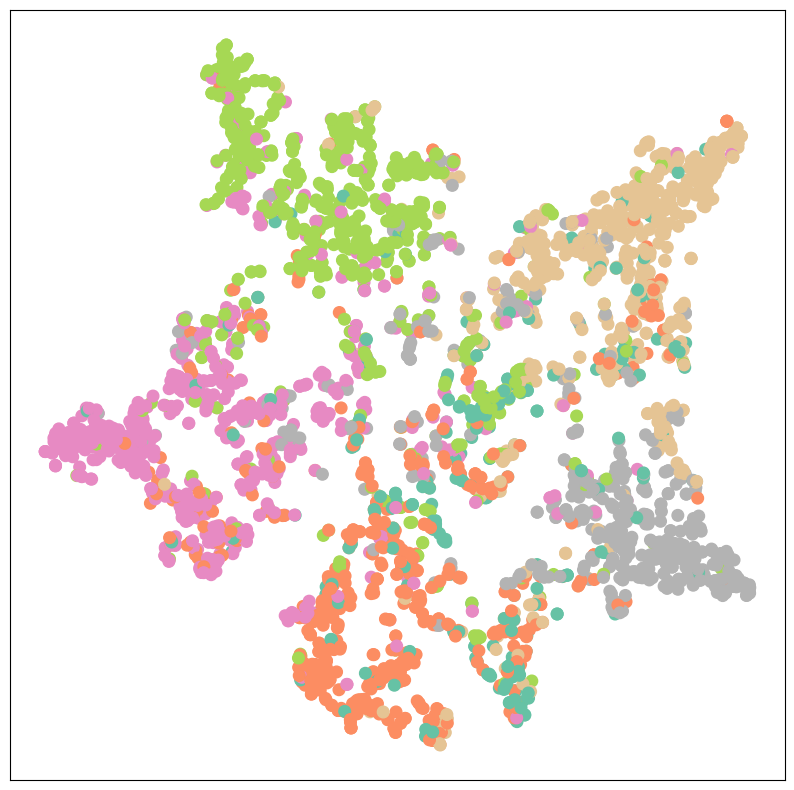

In [25]:
model.eval()

out = model(data, adj)
visualize(out, color=data.y)

Accuracy достаточно хороший. Визуально видна пятиконечная звезда, хотя некоторые пересечения в данных всё же наблюдаются.

По сравнению с GCN accuracy хуже (0.696 против 0.64)